<a href="https://colab.research.google.com/github/deepskies/DeepSLEEP/blob/main/Analysis/12_param_analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lensing summary statistics with a neural net
This is a simulation-based inference of lensing parameters, based on [this notebook](https://github.com/mackelab/sbi/blob/main/tutorials/05_embedding_net.ipynb). The simulator model generates high-dimensional (32 by 32 images) lensing images and we use a convolutional neural network as summary statistics extractor.

---

`sbi` offers functionality to learn summary statistics from (potentially high-dimensional) simulation outputs with a neural network. In `sbi`, this neural network is referred to as `embedding_net`. If an `embedding_net` is specified, the simulation outputs are passed through the `embedding_net`, whose outputs are then passed to the neural density estimator. The parameters of the `embedding_net` are learned together with the parameters of the neural density estimator.

First of all, we import all the packages required for running the tutorial.

**Deeplenstronomy configuration template files can be found in the github folder deeplenstronomy_templates**

We use the lenstronomy package to simulate lenses.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/Colab Notebooks/SBI
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SBI
12_BNN_pos_gauss1.pdf
12_BNN_pos_gauss2.pdf
12_BNN_pos_gauss3.pdf
12_BNN_pos.pdf
12param_BNN_1mil.pkl
12param_BNN_500k.pkl
12param_BNN_800k2.pkl
12param_BNN_800k3.pkl
12param_BNN_800k_42.pkl
12param_BNN_800k_465_gauss1.pkl
12param_BNN_800k_465_gaussian2.pkl
12param_BNN_800k_465_gaussian_3.pkl
12param_BNN_800k_465_gaussian.pkl
12param_BNN_800k_839.pkl
12param_BNN_800k.pkl
12param_BNN_800_test.pkl
12param_BNN_gauss1.pkl
12param_BNN_gauss2.pkl
12param_BNN_gauss3.pkl
12param_BNN.pkl
12param_corner_465.pdf
12_parameter_corner_465.pdf
12_parameter_npe_summary_seed42.pkl
12param_model_1.pkl
12param_model_400_20_42.pkl
12param_model_400k_100hf_20nt_Jason.pkl
12param_model_42_0.pkl
12param_model_42_1.pkl
12param_model_42_1_redo.pkl
12param_model_42_2.pkl
12param_model_42_2_redo.pkl
12param_model_42_3.pkl
12param_model_42_3_redo.pkl
12param_model_42_4_redo.pkl
12param_model_500k_1000hf_10nt_Jason.pkl
12param_model_500k_1000hf_3

In [27]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.1



Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Unins

In [11]:
!pip install tensorflow_probability==0.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 50.8 MB/s eta 0:00:00


In [35]:
!pip install sbi==0.22.0 --quiet
!pip install lenstronomy --quiet
!pip install deeplenstronomy==0.0.2.3
!pip install getdist --quiet
!pip install -q gwpy
!apt-get update
!sudo apt-get install texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra cm-super dvipng --quiet --fix-missing
!pip uninstall pandas -y
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
pandas-gbq 0.24.0 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRel

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils, inference
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
import numpy as np
import scipy as sp
from scipy import stats
import getdist
from getdist import plots, MCSamples
from getdist.styles.tab10 import style_name
plots.set_active_style(style_name)

# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.image_util as image_util
from lenstronomy.Data.psf import PSF

# set seed for numpy and torch
import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image

# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse
import pickle
#from chainconsumer import ChainConsumer

# Colab in order to download files
from google.colab import files


# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp

#import deeplenstronomy.deeplenstronomy as dl
#from deeplenstronomy.visualize import view_image

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pandas
import copy


# Matplotlib, seaborn and plot pretty
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
# rcParams['font.family'] = 'serif'
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from mpl_toolkits.axes_grid1 import make_axes_locatable
#
# # Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=12):
    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines
    return

plot_pretty()

# Pillow
from PIL import Image

#fix seed
np.random.seed(100)

# 1. Loading the trained model

We load our trained model.

In [5]:
class SummaryNet(nn.Module):

    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm2d(128)

        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=128*4*4, out_features=48)

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)

        x = (self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))

        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))

        x = self.bn5(F.relu(self.conv5(x)))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))

        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc(x))
        return x

embedding_net = SummaryNet().to('cuda:0')

from torchsummary import summary
summary(embedding_net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
            Conv2d-3           [-1, 16, 32, 32]           1,168
       BatchNorm2d-4           [-1, 16, 32, 32]              32
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
       BatchNorm2d-7           [-1, 32, 16, 16]              64
            Conv2d-8           [-1, 32, 16, 16]           9,248
       BatchNorm2d-9           [-1, 32, 16, 16]              64
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
      BatchNorm2d-12             [-1, 64, 8, 8]             128
           Conv2d-13            [-1, 128, 8, 8]          73,856
      BatchNorm2d-14            [-1, 12

In [6]:

file_name = "../SBI_WG/Jason/12param_seed42.pkl"
open_file = open(file_name, "rb")
pos_list_400_20_42 = pickle.load(open_file)
open_file.close()


# 2. Simulated-Based Calibration Diagnostics

Now let's run some diagnostics. First we make Simulation-Based Calibration diagnostics, following:


https://www.mackelab.org/sbi/tutorial/13_diagnostics_simulation_based_calibration/


First, we load the training data:

In [13]:
file_name = "../SBI_WG/Jason/12_model_training_des_1M.pkl"
open_file = open(file_name, "rb")
dataset = pickle.load(open_file)
open_file.close()

In [14]:
num_sbc_runs = 10000

theta_E = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][:num_sbc_runs]
le1 = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'][:num_sbc_runs]
le2 = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'][:num_sbc_runs]
x = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'][:num_sbc_runs]
y = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'][:num_sbc_runs]

# These are shear parameters
g1 = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g'][:num_sbc_runs]
g2 = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g'][:num_sbc_runs]

# These are source light parameters - magnitude and parameters of a Sersic profile.
smag = dataset.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'][:num_sbc_runs]
R = dataset.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'][:num_sbc_runs]
n = dataset.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'][:num_sbc_runs]
se1 = dataset.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'][:num_sbc_runs]
se2 = dataset.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'][:num_sbc_runs]

images = torch.FloatTensor(dataset.CONFIGURATION_1_images[:num_sbc_runs].reshape(num_sbc_runs,1,1024))[:,0]
theta = torch.FloatTensor(np.array([theta_E,le1,le2,x,y,g1,g2,smag,R,n,se1,se2]).T)

In [15]:
SBC_images = [images, theta]
file_name = "../SBI_WG/Jason/12param_SBC_training_set.pkl"
open_file = open(file_name, "wb")
pickle.dump(SBC_images, open_file)
open_file.close()

In [16]:
file_name = "../SBI_WG/Jason/12param_SBC_training_set.pkl"
open_file = open(file_name, "rb")
SBC_images = pickle.load(open_file)
open_file.close()

images, theta = SBC_images

In [8]:
#Simulation-Based Calibration
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc,run_sbc, get_nltp, sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

num_posterior_samples = 1000

ranks_42, dap_samples_42 = run_sbc(theta, images, pos_list_400_20_42[0], num_posterior_samples=num_posterior_samples)
check_stats_42 = check_sbc(ranks_42.cpu(), theta.cpu(), dap_samples_42.cpu(), num_posterior_samples=num_posterior_samples)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'thetas' is not defined

In [9]:
check_stats_42 = check_sbc(ranks_42.cpu(), theta.cpu(), dap_samples_42.cpu(), num_posterior_samples=num_posterior_samples)

Let's save the results of this analysis as it takes a while and and we don't want to run it every time.

In [10]:
SBC_arr = [ranks_42, dap_samples_42, check_stats_42]
file_name = "../SBI_WG/Jason/12_param_model_seed42_SBC.pkl"
open_file = open(file_name, "wb")
pickle.dump(SBC_arr, open_file)
open_file.close()

In [11]:
file_name = "../SBI_WG/Jason/12_param_model_seed42_SBC.pkl"
open_file = open(file_name, "rb")
SBC_arr = pickle.load(open_file)
open_file.close()

ranks_42, dap_samples_42, check_stats_42 = SBC_arr

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [9.2985153e-02 5.7069357e-02 7.9339609e-02 1.9289106e-02 4.8110995e-02
 5.0026369e-01 3.3783052e-02 2.2035410e-12 1.9289115e-02 1.1203954e-03
 1.6848411e-01 4.0574676e-01]
c2st accuracies 
check_stats['c2st_ranks'] = [0.5805 0.5865 0.5865 0.5795 0.5835 0.581  0.581  0.5735 0.583  0.5815
 0.58   0.574 ]
- c2st accuracies check_stats['c2st_dap'] = [0.514  0.493  0.493  0.483  0.496  0.499  0.4865 0.508  0.5045 0.502
 0.5065 0.5075]


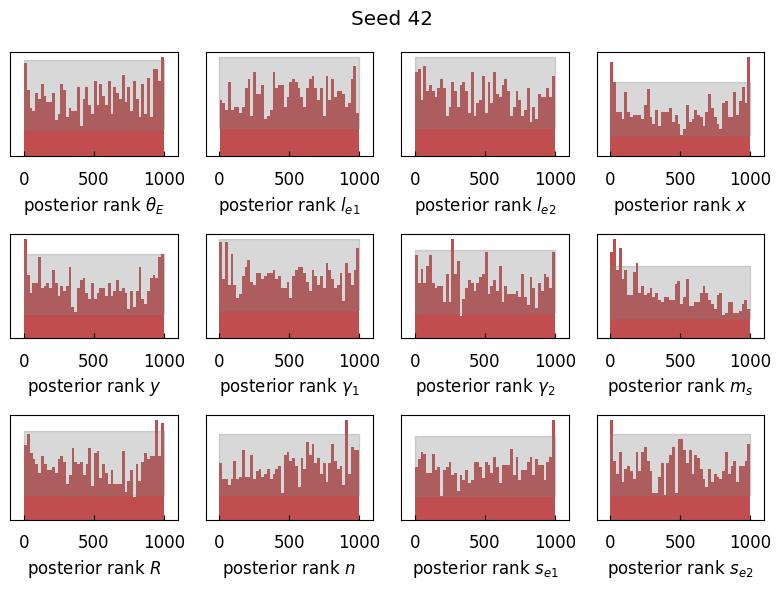

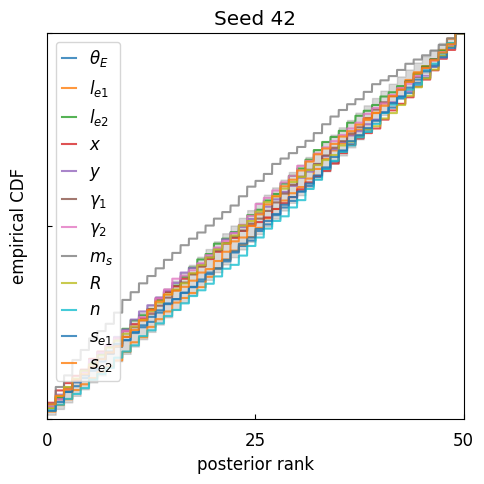

In [12]:

print(f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats_42['ks_pvals'].cpu().numpy()}")
print(f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats_42['c2st_ranks'].cpu().numpy()}")
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats_42['c2st_dap'].cpu().numpy()}")

parameter_labels=[r'$\theta_E$',r'$l_{e1}$',r'$l_{e2}$',r'$x$',r'$y$',r'$\gamma_1$',r'$\gamma_2$',r'$m_s$',r'$R$',r'$n$',r'$s_{e1}$',r'$s_{e2}$']

f,ax=sbc_rank_plot(ranks=ranks_42.cpu(),num_posterior_samples=num_posterior_samples,
             plot_type="hist",
             num_bins=None, parameter_labels=parameter_labels, ranks_labels=[''], figsize = (8,6))
plt.suptitle('Seed 42')
plt.tight_layout()
plt.savefig('12_param_npe_pos_42_sbc_hist.pdf', format='pdf')

f, ax = sbc_rank_plot(ranks_42.cpu(), num_sbc_runs, plot_type = "cdf", parameter_labels=parameter_labels, figsize = (5,5))
plt.title('Seed 42')
plt.tight_layout()
plt.savefig('12_param_npe_pos_42_sbc_cdf.pdf', format='pdf')

# 3. NPE Posterior Coverage Plot


The next diagnostic plot we make is a posterior coverage distribution plot. This plot tells us if our trained neural posterior estimator (NPE) accurately predicts the true uncertainties of the data. In such plots, the x-axis shows different confidence intervals of the posterior volume, and the y-axis shows the fraction of the lenses' true parameter values that fall within that posterior volume. A perfectly calibrated plot should have a line that traces x=y.  

First, we generate our test set. We will also generate a second set with the same parameters but Einstein ring set to zero to get the unlensed source image.



In [15]:
config_file = '../SBI_WG/12_model_test_des_real.yaml'
test_set = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/12_model_test_des_real_source.yaml'
source_set = dl.make_dataset(config_file, return_planes=True)

In [16]:
config_file = '../SBI_WG/12_model_test_des_real_lens_gauss1.yaml'
test_set_gaussian = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/12_model_test_des_real_lens_gauss2.yaml'
test_set_gaussian2 = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/12_model_test_des_real_lens_gauss3.yaml'
test_set_gaussian3 = dl.make_dataset(config_file, return_planes=True)

test_number = 1000

true_theta_E_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]
true_g1_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g'].to_numpy()[:test_number]
true_g2_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g'].to_numpy()[:test_number]
true_smag_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].to_numpy()[:test_number]
true_R_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'].to_numpy()[:test_number]
true_n_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'].to_numpy()[:test_number]
true_se1_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_se2_gaussian = test_set_gaussian.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_array_gaussian = np.array([true_theta_E_gaussian, true_le1_gaussian, true_le2_gaussian, true_x_gaussian, true_y_gaussian, true_g1_gaussian, true_g2_gaussian, true_smag_gaussian, true_R_gaussian, true_n_gaussian, true_se1_gaussian, true_se2_gaussian])
x_observed_gaussian = torch.tensor(test_set_gaussian.CONFIGURATION_1_images.reshape(1000,1,1024),dtype=torch.float32)[:,0]
x_observed_gaussian = torch.tensor(x_observed_gaussian, dtype=torch.float32)

true_theta_E_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]
true_g1_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g'].to_numpy()[:test_number]
true_g2_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g'].to_numpy()[:test_number]
true_smag_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].to_numpy()[:test_number]
true_R_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'].to_numpy()[:test_number]
true_n_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'].to_numpy()[:test_number]
true_se1_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_se2_gaussian2 = test_set_gaussian2.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_array_gaussian2 = np.array([true_theta_E_gaussian2, true_le1_gaussian2, true_le2_gaussian2, true_x_gaussian2, true_y_gaussian2, true_g1_gaussian2, true_g2_gaussian2, true_smag_gaussian2, true_R_gaussian2, true_n_gaussian2, true_se1_gaussian2, true_se2_gaussian2])
x_observed_gaussian2 = torch.tensor(test_set_gaussian2.CONFIGURATION_1_images.reshape(1000,1,1024),dtype=torch.float32)[:,0]
x_observed_gaussian2 = torch.tensor(x_observed_gaussian2, dtype=torch.float32)


true_theta_E_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]
true_g1_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g'].to_numpy()[:test_number]
true_g2_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g'].to_numpy()[:test_number]
true_smag_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].to_numpy()[:test_number]
true_R_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'].to_numpy()[:test_number]
true_n_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'].to_numpy()[:test_number]
true_se1_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_se2_gaussian3 = test_set_gaussian3.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_array_gaussian3 = np.array([true_theta_E_gaussian3, true_le1_gaussian3, true_le2_gaussian3, true_x_gaussian3, true_y_gaussian3, true_g1_gaussian3, true_g2_gaussian3, true_smag_gaussian3, true_R_gaussian3, true_n_gaussian3, true_se1_gaussian3, true_se2_gaussian3])
x_observed_gaussian3 = torch.tensor(test_set_gaussian3.CONFIGURATION_1_images.reshape(1000,1,1024),dtype=torch.float32)[:,0]
x_observed_gaussian3 = torch.tensor(x_observed_gaussian3, dtype=torch.float32)


Now, we produce data for the posterior coverage plot. The below covariance matrix was calculated from the training set data. As it takes a while to calculate this, we have chosen to produce the final matrix.

In [29]:
cov = [[1.15188987e+00,3.41104249e-03,-2.87281764e-03,-8.12286056e-03
,-5.51259279e-03,-9.91957499e-05,5.43193582e-03,-5.41362118e-03
,-8.53666070e-03,-2.12750636e-02,1.43243896e-03,-5.78008025e-03]
,[3.41104249e-03,2.13654715e-01,-4.88649086e-04,-1.86771822e-03
,-3.61725178e-03,-3.83560704e-03,-4.68229587e-04,1.68030562e-02
,2.90037280e-04,-1.30429261e-02,2.33513218e-04,-3.13234396e-04]
,[-2.87281764e-03,-4.88649086e-04,2.12263136e-01,-9.39419430e-03
,-4.06409540e-03,-2.77313317e-03,-2.46581707e-05,-6.91520108e-03
,4.66492039e-03,4.90018888e-03,-6.81281609e-05,3.53645986e-03]
,[-8.12286056e-03,-1.86771822e-03,-9.39419430e-03,1.33355303e+00
,-2.65908649e-03,8.61343088e-03,1.36639754e-03,-3.41583714e-02
,-4.40054938e-03,2.59001754e-02,3.80189458e-03,-7.08057163e-04]
,[-5.51259279e-03,-3.61725178e-03,-4.06409540e-03,-2.65908649e-03
,1.30139565e+00,-3.61026290e-03,7.88821856e-03,-9.74035107e-03
,2.78462974e-02,2.86331802e-02,1.57123708e-03,3.10811417e-03]
,[-9.91957499e-05,-3.83560704e-03,-2.77313317e-03,8.61343088e-03
,-3.61026290e-03,2.14727219e-01,1.80189556e-03,5.12958625e-03
,4.59703902e-03,-2.41795277e-03,-1.28972052e-03,-3.69493543e-03]
,[5.43193582e-03,-4.68229587e-04,-2.46581707e-05,1.36639754e-03
,7.88821856e-03,1.80189556e-03,2.14429414e-01,6.66073618e-03
,-9.56352871e-04,-8.39306023e-03,-4.45445912e-03,3.17706791e-03]
,[-5.41362118e-03,1.68030562e-02,-6.91520108e-03,-3.41583714e-02
,-9.74035107e-03,5.12958625e-03,6.66073618e-03,4.05018523e+00
,1.16593924e-02,6.21058772e-03,5.23039304e-03,1.75341975e-03]
,[-8.53666070e-03,2.90037280e-04,4.66492039e-03,-4.40054938e-03
,2.78462974e-02,4.59703902e-03,-9.56352871e-04,1.16593924e-02
,6.97817582e-01,1.69819552e-03,4.66605440e-03,-3.06495546e-03]
,[-2.12750636e-02,-1.30429261e-02,4.90018888e-03,2.59001754e-02
,2.86331802e-02,-2.41795277e-03,-8.39306023e-03,6.21058772e-03
,1.69819552e-03,4.79149246e+00,7.85295330e-03,-1.56242377e-03]
,[1.43243896e-03,2.33513218e-04,-6.81281609e-05,3.80189458e-03
,1.57123708e-03,-1.28972052e-03,-4.45445912e-03,5.23039304e-03
,4.66605440e-03,7.85295330e-03,2.15645885e-01,1.50339226e-04]
,[-5.78008025e-03,-3.13234396e-04,3.53645986e-03,-7.08057163e-04
,3.10811417e-03,-3.69493543e-03,3.17706791e-03,1.75341975e-03
,-3.06495546e-03,-1.56242377e-03,1.50339226e-04,2.16019102e-01]]

In [18]:
%%capture

test_number = 1000

true_theta_E = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]
true_g1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g'].to_numpy()[:test_number]
true_g2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g'].to_numpy()[:test_number]
true_smag = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].to_numpy()[:test_number]
true_R = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'].to_numpy()[:test_number]
true_n = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'].to_numpy()[:test_number]
true_se1 = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_se2 = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'].to_numpy()[:test_number]

true_array = np.array([true_theta_E, true_le1, true_le2, true_x, true_y, true_g1, true_g2, true_smag, true_R, true_n, true_se1, true_se2])

x_observed = torch.tensor(test_set.CONFIGURATION_1_images.reshape(1000,1,1024),dtype=torch.float32)[:,0]
x_observed = torch.tensor(x_observed, dtype=torch.float32)

def calculate_coverage_fraction(x_observed, pos_list, truth_array, percentile_list, test_number=100, sample_number = 1000):
  count_array = []
  for i in range(test_number):
    samples = pos_list[0].set_default_x(x_observed[i]).sample((sample_number,),show_progress_bars=False)
    count_vector = []
    for ind, cov in enumerate(percentile_list):
      percentile_l = 50.0 - cov/2
      percentile_u = 50.0 + cov/2
      confidence_l = np.percentile(samples.cpu(),percentile_l,axis=0)
      confidence_u = np.percentile(samples.cpu(),percentile_u,axis=0)
      count = np.logical_and(confidence_u - truth_array.T[i] > 0, truth_array.T[i] - confidence_l > 0)
      count_vector.append(count)
    count_array.append(count_vector)
  count_sum_array = np.sum(count_array, axis=0)
  frac_lens_within_vol = np.array(count_sum_array)
  return np.array(frac_lens_within_vol).T/sample_number

def distance(param_vector, mean_vector, covariance):
  d = np.array(param_vector-mean_vector)
  return d.dot(covariance).dot(d.T)

def calculate_coverage_fraction_distance_2(x_observed, pos_list, truth_array, percentile_list, covariance, test_number=100, sample_number = 1000):
  count_array = []
  for i in range(test_number):
    samples = pos_list[0].set_default_x(x_observed[i]).sample((sample_number,),show_progress_bars=False).cpu()
    count_vector = []
    mean = np.median(samples, axis=0)
    for ind, percentile in enumerate(percentile_list):
      d = distance(samples, mean, covariance)
      d_true = distance(truth_array[:,i], mean, covariance)
      d_array = d.diagonal()
      # difference = abs(np.array(samples)-mean)
      # difference_true = abs(.T[i]-mean)
      confidence_l = np.percentile(d_array, percentile, axis=0)
      count = confidence_l - d_true > 0
      count_vector.append(count)
    count_array.append(count_vector)
  return np.sum(np.array(count_array), axis=0)/len(samples)

percentile_array = np.linspace(0,100,21)
# cov = np.cov(theta[:10000].T)
# print(f"{cov}")

In [19]:
frac_array_42 = calculate_coverage_fraction(x_observed,pos_list_400_20_42, true_array, percentile_array, test_number)
frac_array_42_combined = calculate_coverage_fraction_distance_2(x_observed,pos_list_400_20_42, true_array, percentile_array, cov, test_number)


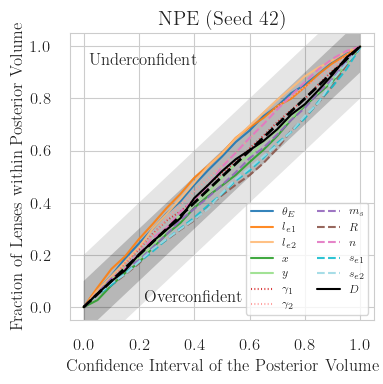

In [20]:
percentile_array = np.linspace(0,100,21)
percentile_array_norm = np.array(percentile_array)/100

from cycler import cycler

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (140, 86, 75),
             (227, 119, 194), (23, 190, 207), (158, 218, 229)]

#(174, 199, 232)

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

default_cycler = (cycler(color=tableau20) + cycler(linestyle=['-','-','-','-','-',':',':','--','--','--','--','--']))

plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)

sns.set_style("whitegrid")
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.plot(percentile_array_norm, frac_array_42.T, alpha = .9)
plt.plot(percentile_array_norm, frac_array_42_combined, c = 'k',ls='-')
plt.plot([0,0.5,1],[0,0.5,1], 'k--', lw=2, zorder=1000)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.1,
    y2=percentile_array_norm+0.1,
    color='k',
    edgecolor="none",
    alpha=0.2,)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.2,
    y2=percentile_array_norm+0.2,
    color='k',
    edgecolor="none",
    alpha=0.1,)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.text(0.02,0.93,'Underconfident', fontsize=12, horizontalalignment='left')
plt.text(0.22,0.02,'Overconfident',fontsize =12, horizontalalignment='left')
plt.legend([r'$\theta_E$',r'$l_{e1}$',r'$l_{e2}$',r'$x$',r'$y$',r'$\gamma_1$',r'$\gamma_2$',r'$m_s$',r'$R$',r'$n$',r'$s_{e1}$',r'$s_{e2}$',r'$D$'],prop={'size': 8},ncol=2,loc=4)
plt.xlabel('Confidence Interval of the Posterior Volume')
plt.ylabel('Fraction of Lenses within Posterior Volume')
plt.title('NPE (Seed 42)')
plt.tight_layout()

In [21]:
print("frac_array_42 =",frac_array_42.tolist())
print("frac_array_42_combined =",frac_array_42_combined.tolist())

frac_array_42 = [[0.0, 0.064, 0.12, 0.187, 0.244, 0.301, 0.359, 0.406, 0.469, 0.525, 0.577, 0.633, 0.677, 0.732, 0.77, 0.82, 0.853, 0.895, 0.939, 0.977, 1.0], [0.0, 0.075, 0.146, 0.195, 0.261, 0.319, 0.38, 0.434, 0.496, 0.542, 0.59, 0.649, 0.69, 0.725, 0.771, 0.799, 0.844, 0.894, 0.935, 0.967, 0.999], [0.0, 0.064, 0.119, 0.173, 0.229, 0.302, 0.357, 0.416, 0.478, 0.541, 0.589, 0.647, 0.695, 0.745, 0.795, 0.839, 0.885, 0.919, 0.946, 0.98, 0.999], [0.0, 0.027, 0.083, 0.131, 0.171, 0.228, 0.28, 0.323, 0.381, 0.426, 0.466, 0.507, 0.556, 0.603, 0.656, 0.718, 0.772, 0.819, 0.865, 0.932, 0.995], [0.0, 0.049, 0.101, 0.155, 0.187, 0.237, 0.294, 0.353, 0.397, 0.44, 0.497, 0.549, 0.581, 0.634, 0.677, 0.722, 0.777, 0.826, 0.872, 0.931, 0.999], [0.0, 0.05, 0.103, 0.167, 0.222, 0.281, 0.332, 0.367, 0.412, 0.469, 0.514, 0.558, 0.608, 0.657, 0.709, 0.755, 0.799, 0.855, 0.906, 0.951, 0.998], [0.0, 0.044, 0.109, 0.167, 0.228, 0.275, 0.339, 0.391, 0.444, 0.493, 0.543, 0.593, 0.646, 0.703, 0.768, 0.806, 0.

# 4. Accuracy and Precision of the max-likelihood values of the ensemble.

So far, we've looked at the quality of our posterior volumes. Now, we'll look at the distribution of our max-likelihood values.

In [20]:
%%capture
import gc

x_observed = torch.tensor(test_set.CONFIGURATION_1_images.reshape(1000,1,1024),dtype=torch.float32)[:,0]
x_observed = torch.tensor(x_observed, dtype=torch.float32)

def make_summary_statistic_array(x_observed, posterior, test_number = 1000):

  SBI_median_arr = []
  SBI_max_like_arr = []
  SBI_percentile68u_arr = []
  SBI_percentile68l_arr = []
  SBI_percentile95u_arr = []
  SBI_percentile95l_arr = []
  SBI_sample_array = []
  SBI_logp_array = []
  SBI_map_array = []

  for k in range(len(posterior)):
    # This iterates over multiple SBI networks. If you only have one, len(posterior) should be 1.
    median_arr = []
    max_like_arr = []
    percentile68u_arr = []
    percentile68l_arr = []
    percentile95u_arr = []
    percentile95l_arr = []
    sample_array = []
    logp_array = []
    map_array = []
    for j in range(test_number):
      # This iterates over the number of images in the test set. If you only have one, test_number should be 1.
      median = []
      max_like = []
      percentile68u = []
      percentile68l = []
      percentile95u = []
      percentile95l = []
      samples = posterior[k].set_default_x(x_observed[j]).sample((1000,))
      # map = posterior[k].map(x=x_observed[j])
      # map_array.append(map.cpu().numpy())
      sample_array.append(samples.cpu())
      logp = posterior[k].log_prob(samples)
      logp_array.append(logp.cpu())
      argmaxlogp = torch.argmax(posterior[k].log_prob(samples))
      for i in range(len(samples[0])):
        # This iterates over the number of parameters per image.
        max_like.append(float(samples.cpu()[argmaxlogp][i]))
        median.append(np.median(samples.cpu()[:,i]))
        percentile68l.append(np.percentile(samples.cpu()[:,i],16))
        percentile68u.append(np.percentile(samples.cpu()[:,i],84))
        percentile95l.append(np.percentile(samples.cpu()[:,i],2.5))
        percentile95u.append(np.percentile(samples.cpu()[:,i],97.5))
      median_arr.append(median)
      max_like_arr.append(max_like)
      percentile68l_arr.append(percentile68l)
      percentile68u_arr.append(percentile68u)
      percentile95l_arr.append(percentile95l)
      percentile95u_arr.append(percentile95u)
    SBI_median_arr.append(median_arr)
    SBI_max_like_arr.append(max_like_arr)
    SBI_percentile68u_arr.append(percentile68u_arr)
    SBI_percentile68l_arr.append(percentile68l_arr)
    SBI_percentile95u_arr.append(percentile95u_arr)
    SBI_percentile95l_arr.append(percentile95l_arr)
    SBI_sample_array.append(sample_array)
    SBI_logp_array.append(logp_array)
    # SBI_map_array.append(map_array)

  SBI_median_arr = np.array(SBI_median_arr)
  SBI_max_like_arr = np.array(SBI_max_like_arr)
  SBI_percentile68u_arr = np.array(SBI_percentile68u_arr)
  SBI_percentile68l_arr = np.array(SBI_percentile68l_arr)
  SBI_percentile95u_arr = np.array(SBI_percentile95u_arr)
  SBI_percentile95l_arr = np.array(SBI_percentile95l_arr)
  SBI_sample_array = np.array(SBI_sample_array)
  SBI_logp_array = np.array(SBI_logp_array)
  # SBI_map_array = np.array(SBI_map_array)

  return SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_median_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr

array_dump = make_summary_statistic_array(x_observed, pos_list_400_20_42, 1000)

import pickle
file_name = "12_parameter_npe_summary_seed42.pkl"
open_file = open(file_name, "wb")
pickle.dump(array_dump, open_file)
open_file.close()

In [39]:
import pickle
file_name = "12_parameter_npe_summary_seed42.pkl"
open_file = open(file_name, "rb")
array_dump = pickle.load(open_file)
open_file.close()

## We want to compare the accuracy and precision of our model to a BNN. Here, we load the BNN model and evaluate its performance on the test set by generating the same summary statistics.

In [13]:
# Define basic numbers
IMAGE_SHAPE = [32, 32, 1]
NUM_TRAIN_EXAMPLES = 1000000

tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.

kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

def load_model(location):

  model_input = Input(shape=(32,32,1))

  # Convolutional part =================
  # 1st convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 16,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(model_input)
  x = tfp.layers.Convolution2DFlipout(
          filters = 16,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(model_input)
  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # 2nd convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 32,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 32,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # 3rd convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 48,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 48,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # 4th convolutional chunk
  x = tfp.layers.Convolution2DFlipout(
          filters = 64,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 64,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)
  x = tfp.layers.Convolution2DFlipout(
          filters = 64,
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.leaky_relu)(x)

  x = keras.layers.MaxPool2D(pool_size=(2, 2),
                                strides=None,
                                padding='valid')(x)

  # ====================================
  x = keras.layers.Flatten()(x)
  # ====================================

  x = tfp.layers.DenseFlipout(
          units = 2048,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.tanh)(x)
  x = tfp.layers.DenseFlipout(
          units = 512,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.tanh)(x)
  x = tfp.layers.DenseFlipout(
          units = 64,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.tanh)(x)
  distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(12))(x)
  model_output = tfp.layers.MultivariateNormalTriL(event_size=12)(distribution_params)
  model = Model(model_input, model_output)

  model.load_weights(location)

  return model

model = load_model('../SBI_WG/Jason/12param_1M_200k_600epochs_BNN.h5')

In [16]:
def make_summary_statistic_BNN(test_set, model, test_number = 1000):
  pred_array = []
  X_0 = test_set.CONFIGURATION_1_images
  X_0 = np.moveaxis(X_0,1,-1)[:test_number]

  n_rands = 100
  pred_dist = model(X_0)
  sample= np.asarray(pred_dist.sample(n_rands))
  for i in range(n_rands):
    pred_dist = model(X_0)
    sample_loc = np.asarray(pred_dist.sample(n_rands))
    sample = np.concatenate((sample,sample_loc))
  return sample

BNNsamples = make_summary_statistic_BNN(test_set, model, test_number = 1000)


In [18]:
file_name = "12param_BNN_800_test.pkl"
open_file = open(file_name, "wb")
pickle.dump(BNNsamples, open_file)
open_file.close()

In [19]:
file_name = "12param_BNN_800_test.pkl"
open_file = open(file_name, "rb")
BNNsamples = pickle.load(open_file)
open_file.close()

## Finally, we put the NPE and BNN inference statistics together and make a ensemble diagnostic plot.

In [40]:
SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_median_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr = array_dump

test_number = 1000

max_cut = SBI_max_like_arr[0,:test_number,:]-true_array.T
max_cut_ext = np.append(max_cut, SBI_max_like_arr[0,:test_number,:],axis=1)
error = SBI_percentile68u_arr[0,:test_number,:] - SBI_percentile68l_arr[0,:test_number,:]

max_cut_norm = max_cut/error
max_cut_ext_norm = np.append(max_cut_norm, SBI_max_like_arr[0,:test_number,:], axis=1)

pred_med_array = np.median(BNNsamples,axis=0)
BNN_diff = pred_med_array-true_array.T

BNN_diff_ext = np.append(BNN_diff, pred_med_array[:test_number,:], axis=1)

BNN_error = np.percentile(BNNsamples,84,axis=0) - np.percentile(BNNsamples,16,axis=0)

BNN_diff_norm = BNN_diff/BNN_error
BNN_diff_ext_norm = np.append(BNN_diff_norm, pred_med_array[:test_number,:], axis=1)

BNN_norm_one = np.divide(BNN_diff_norm, np.percentile(BNN_diff_norm,84,axis=0) - np.percentile(BNN_diff_norm,16,axis=0))*2
BNN_norm_one_ext = np.append(BNN_norm_one, pred_med_array[:test_number,:], axis=1)

SBI_norm_one = np.divide(max_cut_norm,np.percentile(max_cut_norm,84,axis=0) - np.percentile(max_cut_norm,16,axis=0))*2
SBI_norm_one_ext = np.append(SBI_norm_one, SBI_max_like_arr[0,:test_number,:], axis=1)

SBIsamples_plot_norm_one = MCSamples(samples=max_cut_ext,
                            names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}', r'\theta_E_t','le1_t','le2_t','x_t','y_t','g1_t','g2_t','smag_t','R_t','n_t','se1_t','se2_t'],
                      labels = [r'\Delta \theta_E',r'\Delta l_{e1}',r'\Delta l_{e2}',r'\Delta x',r'\Delta y',r'\Delta \gamma_1',r'\Delta \gamma_2',r'\Delta m_s',r'\Delta R',r'\Delta n',r'\Delta s_{e1}',r'\Delta s_{e2}', r'\theta_E_t','le1_t','le2_t','x_t','y_t','g1_t','g2_t','smag_t','R_t','n_t','se1_t','se2_t'])

BNNsamples_plot_norm_one = MCSamples(samples=BNN_diff_ext,
                            names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}', r'\theta_E_t','le1_t','le2_t','x_t','y_t','g1_t','g2_t','smag_t','R_t','n_t','se1_t','se2_t'],
                       labels = [r'\Delta \theta_E',r'\Delta l_{e1}',r'\Delta l_{e2}',r'\Delta x',r'\Delta y',r'\Delta \gamma_1',r'\Delta \gamma_2',r'\Delta m_s',r'\Delta R',r'\Delta n',r'\Delta s_{e1}',r'\Delta s_{e2}', r'\theta_E_t','le1_t','le2_t','x_t','y_t','g1_t','g2_t','smag_t','R_t','n_t','se1_t','se2_t'])


Removed no burn in
Removed no burn in


In [ ]:
sns.reset_defaults()

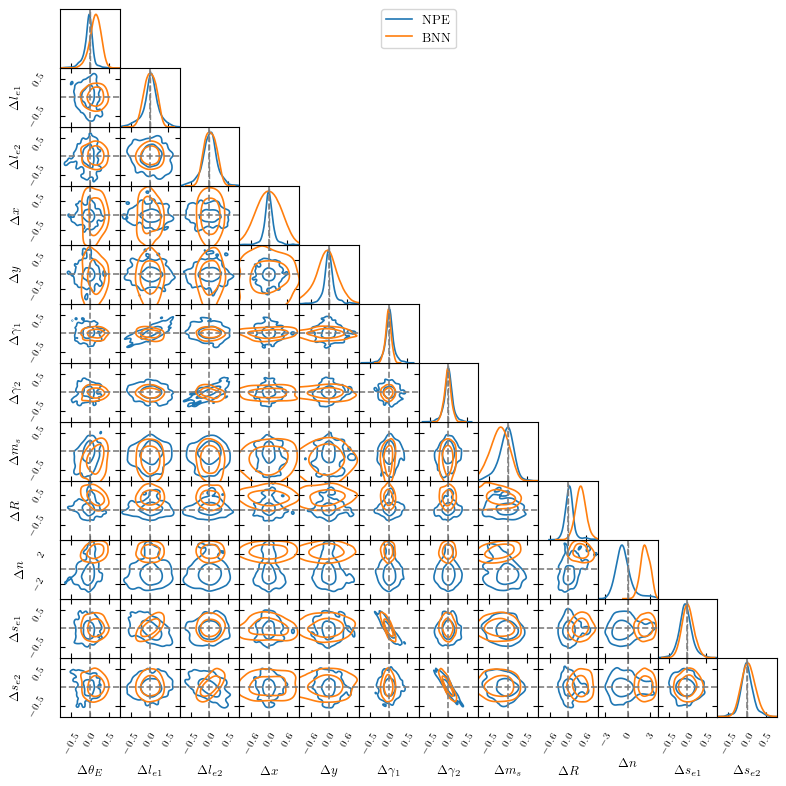

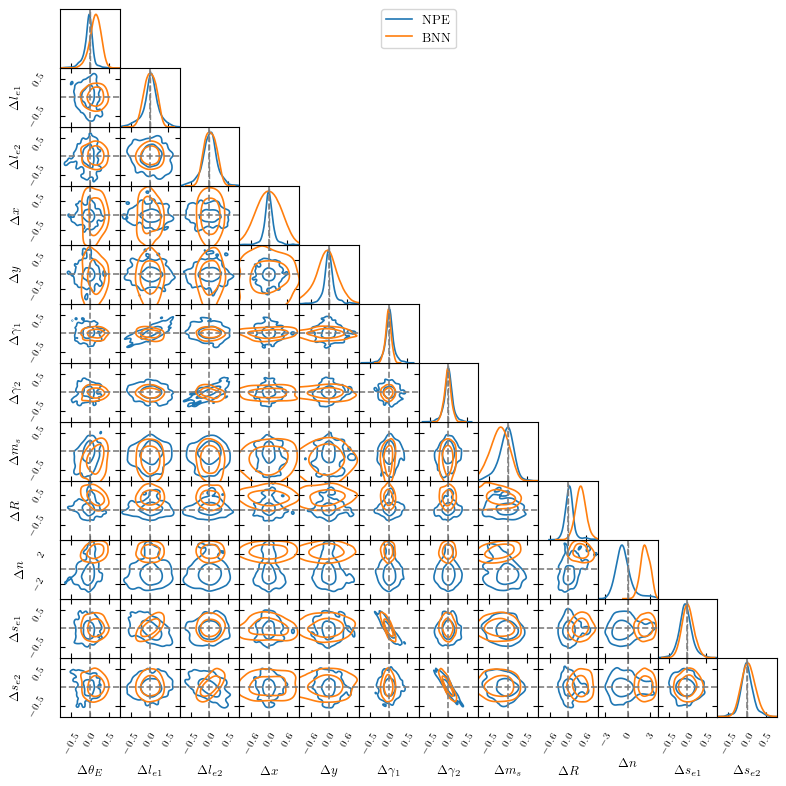

In [56]:
plot_pretty()
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

g = plots.get_subplot_plotter(width_inch=8)
g.settings.axes_fontsize=10
g.settings.axes_labelsize=12
g.settings.axis_tick_x_rotation=60
g.settings.axis_tick_y_rotation=60
g.settings.scaling_factor = 1
g.settings.linewidth=1
g.settings.title_limit_labels = False
g.settings.title_limit_fontsize = 8
g.triangle_plot([SBIsamples_plot_norm_one, BNNsamples_plot_norm_one],[r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'], legend_labels=['NPE','BNN'],
                colors=['tab:blue','tab:orange'],
                contour_lws=1.2,
                line_args=[{'color':'tab:blue', 'lw':1},{'color':'tab:orange', 'lw':1}],
                markers={r'\theta_E':0,r'l_{e1}':0,r'l_{e2}':0,r'x':0,r'y':0,r'\gamma_1':0,r'\gamma_2':0,r'm_s':0,r'R':0,r'n':0,r's_{e1}':0,r's_{e2}':0},
                marker_args ={'lw':1.2},
                param_limits = {r'\theta_E':[-0.8,0.8],r'l_{e1}':[-0.8,0.8],r'l_{e2}':[-0.8,0.8],r'x':[-1,1],r'y':[-1,1],r'\gamma_1':[-0.8,0.8],r'\gamma_2':[-0.8,0.8],r'm_s':[-0.8,0.8],r'R':[-1,1],r'n':[-4,4],r's_{e1}':[-0.8,0.8],r's_{e2}':[-0.8,0.8]},
                title_limit=0)
for i in range(len(g.subplots[0,:])):
  g.subplots[i,i].axvline(color='gray', ls='--', lw=1)
plt.savefig('12_parameter_corner_42.pdf',format='pdf')

# 6. BNN Posterior Coverage


Since we have the BNN model loaded, let's make posterior coverage plots so we can compare the BNN's performance with the NPE model.

In [26]:
test_number = 1000

true_theta_E = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[:test_number]
true_le1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_le2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[:test_number]
true_x = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[:test_number]
true_y = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[:test_number]
true_g1 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g'].to_numpy()[:test_number]
true_g2 = test_set.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g'].to_numpy()[:test_number]
true_smag = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].to_numpy()[:test_number]
true_R = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'].to_numpy()[:test_number]
true_n = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'].to_numpy()[:test_number]
true_se1 = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'].to_numpy()[:test_number]
true_se2 = test_set.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'].to_numpy()[:test_number]

true_array = np.array([true_theta_E, true_le1, true_le2, true_x, true_y, true_g1, true_g2, true_smag, true_R, true_n, true_se1, true_se2])
def calculate_coverage_fraction_BNN(samples, truth_array, percentile_list, test_number=100, sample_number = 1000):
  count_vector = []
  for ind, cov in enumerate(percentile_list):
    percentile_l = 50.0 - cov/2
    percentile_u = 50.0 + cov/2
    confidence_l = np.percentile(samples,percentile_l,axis=0)
    confidence_u = np.percentile(samples,percentile_u,axis=0)
    count = np.logical_and(confidence_u - truth_array.T > 0, truth_array.T - confidence_l > 0)
    count_vector.append(count)
  count_sum_array = np.sum(count_vector, axis=1)
  frac_lens_within_vol = np.array(count_sum_array)
  return np.array(frac_lens_within_vol).T/sample_number

def distance(param_vector, mean_vector, covariance):
  d = np.array(param_vector-mean_vector)
  return d.dot(covariance).dot(d.T)

def calculate_coverage_fraction_distance_BNN(input_samples, truth_array, percentile_list, covariance, test_number=100, sample_number = 1000):
  count_array = []
  rng = np.random.default_rng()
  for i in range(test_number):
    samples = rng.choice(input_samples, size=1000, replace=False, axis=0)[:,i,:]
    # samples = input_samples[:1000,i,:]
    count_vector = []
    mean = np.median(samples, axis=0)
    for ind, percentile in enumerate(percentile_list):
      d = distance(samples, mean, cov)
      d_true = distance(truth_array[:,i], mean, covariance)
      d_array = d.diagonal()
      # difference = abs(np.array(samples)-mean)
      # difference_true = abs(.T[i]-mean)
      confidence_l = np.percentile(d_array, percentile, axis=0)
      count = confidence_l - d_true > 0
      count_vector.append(count)
    count_array.append(count_vector)
  return np.sum(np.array(count_array), axis=0)/test_number

percentile_array = np.linspace(0,100,21)

In [30]:
cov = [[1.15188987e+00,3.41104249e-03,-2.87281764e-03,-8.12286056e-03
,-5.51259279e-03,-9.91957499e-05,5.43193582e-03,-5.41362118e-03
,-8.53666070e-03,-2.12750636e-02,1.43243896e-03,-5.78008025e-03]
,[3.41104249e-03,2.13654715e-01,-4.88649086e-04,-1.86771822e-03
,-3.61725178e-03,-3.83560704e-03,-4.68229587e-04,1.68030562e-02
,2.90037280e-04,-1.30429261e-02,2.33513218e-04,-3.13234396e-04]
,[-2.87281764e-03,-4.88649086e-04,2.12263136e-01,-9.39419430e-03
,-4.06409540e-03,-2.77313317e-03,-2.46581707e-05,-6.91520108e-03
,4.66492039e-03,4.90018888e-03,-6.81281609e-05,3.53645986e-03]
,[-8.12286056e-03,-1.86771822e-03,-9.39419430e-03,1.33355303e+00
,-2.65908649e-03,8.61343088e-03,1.36639754e-03,-3.41583714e-02
,-4.40054938e-03,2.59001754e-02,3.80189458e-03,-7.08057163e-04]
,[-5.51259279e-03,-3.61725178e-03,-4.06409540e-03,-2.65908649e-03
,1.30139565e+00,-3.61026290e-03,7.88821856e-03,-9.74035107e-03
,2.78462974e-02,2.86331802e-02,1.57123708e-03,3.10811417e-03]
,[-9.91957499e-05,-3.83560704e-03,-2.77313317e-03,8.61343088e-03
,-3.61026290e-03,2.14727219e-01,1.80189556e-03,5.12958625e-03
,4.59703902e-03,-2.41795277e-03,-1.28972052e-03,-3.69493543e-03]
,[5.43193582e-03,-4.68229587e-04,-2.46581707e-05,1.36639754e-03
,7.88821856e-03,1.80189556e-03,2.14429414e-01,6.66073618e-03
,-9.56352871e-04,-8.39306023e-03,-4.45445912e-03,3.17706791e-03]
,[-5.41362118e-03,1.68030562e-02,-6.91520108e-03,-3.41583714e-02
,-9.74035107e-03,5.12958625e-03,6.66073618e-03,4.05018523e+00
,1.16593924e-02,6.21058772e-03,5.23039304e-03,1.75341975e-03]
,[-8.53666070e-03,2.90037280e-04,4.66492039e-03,-4.40054938e-03
,2.78462974e-02,4.59703902e-03,-9.56352871e-04,1.16593924e-02
,6.97817582e-01,1.69819552e-03,4.66605440e-03,-3.06495546e-03]
,[-2.12750636e-02,-1.30429261e-02,4.90018888e-03,2.59001754e-02
,2.86331802e-02,-2.41795277e-03,-8.39306023e-03,6.21058772e-03
,1.69819552e-03,4.79149246e+00,7.85295330e-03,-1.56242377e-03]
,[1.43243896e-03,2.33513218e-04,-6.81281609e-05,3.80189458e-03
,1.57123708e-03,-1.28972052e-03,-4.45445912e-03,5.23039304e-03
,4.66605440e-03,7.85295330e-03,2.15645885e-01,1.50339226e-04]
,[-5.78008025e-03,-3.13234396e-04,3.53645986e-03,-7.08057163e-04
,3.10811417e-03,-3.69493543e-03,3.17706791e-03,1.75341975e-03
,-3.06495546e-03,-1.56242377e-03,1.50339226e-04,2.16019102e-01]]

In [31]:
frac_array_BNN = calculate_coverage_fraction_BNN(BNNsamples, true_array, percentile_array, test_number)
frac_array_BNN_com = calculate_coverage_fraction_distance_BNN(BNNsamples, true_array, percentile_array, cov, test_number=1000)
print("frac_array_BNN_com =",frac_array_BNN_com.tolist())
print("frac_array_BNN =",frac_array_BNN.tolist())

frac_array_BNN_com = [0.0, 0.001, 0.003, 0.003, 0.005, 0.017, 0.025, 0.037, 0.051, 0.074, 0.099, 0.143, 0.212, 0.295, 0.411, 0.546, 0.68, 0.827, 0.948, 0.998, 1.0]
frac_array_BNN = [[0.0, 0.084, 0.164, 0.269, 0.367, 0.494, 0.608, 0.709, 0.812, 0.893, 0.943, 0.973, 0.989, 0.994, 0.998, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.111, 0.2, 0.31, 0.418, 0.505, 0.588, 0.676, 0.76, 0.839, 0.898, 0.936, 0.969, 0.992, 0.997, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.099, 0.19, 0.306, 0.403, 0.502, 0.605, 0.689, 0.781, 0.847, 0.903, 0.944, 0.969, 0.989, 0.997, 0.999, 0.999, 1.0, 1.0, 1.0, 1.0], [0.0, 0.082, 0.171, 0.241, 0.336, 0.428, 0.494, 0.575, 0.644, 0.696, 0.751, 0.795, 0.844, 0.887, 0.928, 0.957, 0.975, 0.991, 0.998, 0.999, 1.0], [0.0, 0.137, 0.244, 0.369, 0.479, 0.554, 0.642, 0.717, 0.778, 0.816, 0.86, 0.903, 0.92, 0.937, 0.957, 0.969, 0.979, 0.991, 0.999, 1.0, 1.0], [0.0, 0.141, 0.284, 0.405, 0.497, 0.615, 0.692, 0.756, 0.813, 0.869, 0.899, 0.94, 0.964, 0.981, 0.992, 0.997, 1.0, 1.0, 1.0,

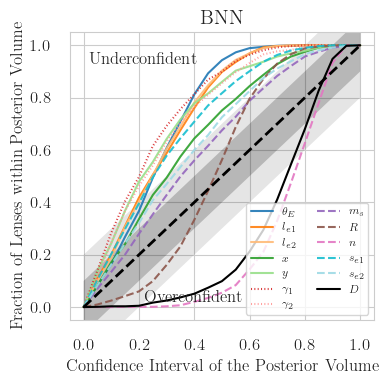

In [32]:
percentile_array = np.linspace(0,100,21)
percentile_array_norm = np.array(percentile_array)/100

from cycler import cycler

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (140, 86, 75),
             (227, 119, 194), (23, 190, 207), (158, 218, 229)]

#(174, 199, 232)

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

default_cycler = (cycler(color=tableau20) + cycler(linestyle=['-','-','-','-','-',':',':','--','--','--','--','--']))

plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)

sns.set_style("whitegrid")
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.plot(percentile_array_norm, frac_array_BNN.T, alpha = 0.9)
plt.plot(percentile_array_norm, frac_array_BNN_com, c = 'k',ls='-')
plt.plot([0,0.5,1],[0,0.5,1], 'k--', lw=2, zorder=1000)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.1,
    y2=percentile_array_norm+0.1,
    color='k',
    edgecolor="none",
    alpha=0.2,)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.2,
    y2=percentile_array_norm+0.2,
    color='k',
    edgecolor="none",
    alpha=0.1,)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.text(0.02,0.93,'Underconfident', fontsize=12, horizontalalignment='left')
plt.text(0.22,0.02,'Overconfident',fontsize =12, horizontalalignment='left')
plt.legend([r'$\theta_E$',r'$l_{e1}$',r'$l_{e2}$',r'$x$',r'$y$',r'$\gamma_1$',r'$\gamma_2$',r'$m_s$',r'$R$',r'$n$',r'$s_{e1}$',r'$s_{e2}$',r'$D$'],prop={'size': 8},ncol=2,loc=4)
plt.xlabel('Confidence Interval of the Posterior Volume')
plt.ylabel('Fraction of Lenses within Posterior Volume')
plt.title('BNN')
plt.tight_layout()
plt.savefig('12_BNN_test.pdf',format='pdf')

# 7. Individual Lenses

Now, we will look at the first few images in the test, plotting the simulated data, the best-fit model image predicted from the posterior estimator, and the residual plots. We then plot the parameter corner plot.

First, we make some plotting functions.

In [43]:
def plot_residuals(observed_image, model_image, observed_source_image, model_source_image,name):
  fig, ax = plt.subplots(1,6,figsize=(9,3.1),sharex='col', sharey='row')
  plt.set_cmap('viridis')
  normalization = observed_image
  # vmin = np.amin(normalization)
  vmax = np.amax(normalization)
  vmin = -vmax

  # vmin=-20
  # vmax=20
  #This is the observed image
  ax[0].set_title("Observed Lens")
  data_lens = ax[0].imshow(observed_image, vmin=vmin, vmax=vmax, interpolation='none')
  ax[0].axis('off')

  #This is the model image
  ax[1].set_title("Model Lens")
  ax[1].imshow(model_image, vmin=vmin, vmax=vmax, interpolation='none')
  ax[1].axis('off')

  #This is the residuals
  ax[2].set_title("Lens Residuals")
  resid_lens = ax[2].imshow(model_image-observed_image,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[2].axis('off')

  ax[3].set_title("Observed Source")
  ax[3].imshow(observed_source_image,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[3].axis('off')

  ax[4].set_title("Model Source")
  ax[4].imshow(model_source_image,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[4].axis('off')

  # #This is the residuals
  ax[5].set_title("Source Residuals")
  resid_source = ax[5].imshow(model_source_image-observed_source_image,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[5].axis('off')

  fig.colorbar(data_lens, ax=ax[:], location='bottom', pad = 0.02)
  fig.suptitle(name, y=0.75, fontsize=14)
  # plt.tight_layout()

  return fig, ax

def plot_residuals_source(observed_image, model_image, observed_source_image, model_source_image,name):
  sns.set_style("white")
  fig, ax = plt.subplots(2,3,figsize=(5,5))
  fig.suptitle(name)

  normalization = observed_image
  normalization_source = observed_source_image
  vmax = np.amax(normalization)
  vmin = -vmax
  vmax_source = np.amax(normalization_source)
  vmin_source = -vmax_source

  #This is the observed image
  ax[0,0].set_title("Observed Lens")
  ax[0,0].imshow(observed_image, vmin=vmin, vmax=vmax)
  ax[0,0].axis('off')

  ax[1,0].set_title("Observed Source")
  ax[1,0].imshow(observed_source_image,  vmin=vmin_source, vmax=vmax_source)
  ax[1,0].axis('off')

  #This is the model image
  ax[0,1].set_title("Model Lens")
  ax[0,1].imshow(model_image, vmin=vmin, vmax=vmax)
  ax[0,1].axis('off')

  ax[1,1].set_title("Model Source")
  ax[1,1].imshow(model_source_image,  vmin=vmin_source, vmax=vmax_source)
  ax[1,1].axis('off')

  #This is the residuals
  ax[0,2].set_title("Lens plane Residuals")
  ax[0,2].axis('off')
  resid_lens = ax[0,2].imshow(model_image-observed_image,  vmin=vmin, vmax=vmax)
  fig.colorbar(resid_lens,ax=ax[0,:], location='right', pad = 0.02)

  ax[1,2].set_title("Source plane Residuals")
  ax[1,2].axis('off')
  resid_source = ax[1,2].imshow(model_source_image-observed_source_image,  vmin=vmin_source, vmax=vmax_source)
  fig.colorbar(resid_source,ax=ax[1,:], location='right', pad = 0.02)

  plt.tight_layout
  return fig, ax

def update_image_source(model, model_source, new_param, index):

  # model_source = copy.copy(model)

  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g': new_param[0]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g': new_param[1]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g': new_param[2]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g': new_param[3]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g': new_param[4]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g': new_param[5]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g': new_param[6]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g': new_param[7]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g': new_param[8]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g': new_param[9]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g': new_param[10]}, 'CONFIGURATION_1')
  model.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g': new_param[11]}, 'CONFIGURATION_1')
  model.regenerate(return_planes=True)

  model_source.update_param({'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g': 0}, 'CONFIGURATION_1')
  model_source.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g': new_param[7]}, 'CONFIGURATION_1')
  model_source.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g': new_param[8]}, 'CONFIGURATION_1')
  model_source.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g': new_param[9]}, 'CONFIGURATION_1')
  model_source.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g': new_param[10]}, 'CONFIGURATION_1')
  model_source.update_param({'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g': new_param[11]}, 'CONFIGURATION_1')
  model_source.regenerate(return_planes=True)

  image = model.CONFIGURATION_1_images[index][0]
  # source = model_source.CONFIGURATION_1_images[index][0]
  source = model_source.CONFIGURATION_1_planes[index][1,0]
  return image, source

def plot_residuals_combined(observed_image_1, model_image_1, observed_source_image_1, model_source_image_1, name_1, observed_image_2, model_image_2, observed_source_image_2, model_source_image_2, name_2):
  fig, ax = plt.subplots(2,7,figsize=(10.4,3),sharex='col', sharey='row', layout='compressed', width_ratios=[1, 1, 1, 0.01, 1, 1, 1])

  plt.set_cmap('viridis')
  normalization = observed_image_1
  # vmin = np.amin(normalization)
  vmax = np.amax(normalization)
  vmin = -vmax

  # vmin=-20
  # vmax=20
  #This is the observed image
  ax[0,0].set_title("True")
  ax[0,0].imshow(observed_image_1, vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,0].axis('off')
  # ax[0,0].set_title('NPE', loc='left')

  # ax[1,0].set_title("Observed Lens")
  ax[1,0].imshow(observed_image_2, vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,0].axis('off')
  # ax[1,0].set_title('BNN')

  #This is the model image
  ax[0,1].set_title("Model")
  ax[0,1].imshow(model_image_1, vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,1].axis('off')
  # ax[0,1].set_title('Lens Plane')

  # ax[1,1].set_title("Model Lens")
  ax[1,1].imshow(model_image_2, vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,1].axis('off')

  #This is the residuals
  ax[0,2].set_title("Residuals")
  resid_lens_1 = ax[0,2].imshow(model_image_1-observed_image_1,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,2].axis('off')

  # ax[1,2].set_title("Lens Residuals")
  resid_lens2 = ax[1,2].imshow(model_image_2-observed_image_2,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,2].axis('off')

  ax[0,3].set_visible(False)
  ax[1,3].set_visible(False)

  ax[0,4].set_title("True")
  data_color = ax[0,4].imshow(observed_source_image_1,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,4].axis('off')

  # ax[1,3].set_title("Observed Source")
  ax[1,4].imshow(observed_source_image_2,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,4].axis('off')

  ax[0,5].set_title("Model")
  ax[0,5].imshow(model_source_image_1,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,5].axis('off')
  # ax[0,4].set_title('Source Plane')

  # ax[1,4].set_title("Model Source")
  ax[1,5].imshow(model_source_image_2,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,5].axis('off')

  # #This is the residuals
  ax[0,6].set_title("Residuals")
  resid_source1 = ax[0,6].imshow(model_source_image_1-observed_source_image_1,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[0,6].axis('off')

  # ax[1,5].set_title("Source Residuals")
  resid_source2 = ax[1,6].imshow(model_source_image_2-observed_source_image_2,  vmin=vmin, vmax=vmax, interpolation='none')
  ax[1,6].axis('off')

  # plt.colorbar(data_color, ax = ax[:,5])
  # fig.suptitle(name, y=0.75, fontsize=14)
  plt.colorbar(resid_source1, ax = ax, pad=0.01, orientation="vertical", label = 'Flux ($e^{-}/s)$')
  fig.text(0.01,0.68, 'NPE', fontsize=14)
  fig.text(0.01,0.23, 'BNN', fontsize=14)
  fig.text(0.2,1.04, r'Lens Plane', fontsize=16)
  fig.text(0.605,1.04, r'Source Plane', fontsize=16)
  # line = plt.Line2D((.45709,.45709),(0,1.05), color="k", linewidth=1)
  # fig.add_artist(line)
  # plt.tight_layout()

  return fig, ax

def plot_pretty(dpi=200, fontsize=11):
    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines
    return

plot_pretty()

Now, we plot the simulated image and model predictions, and source plane image for the individual lens.

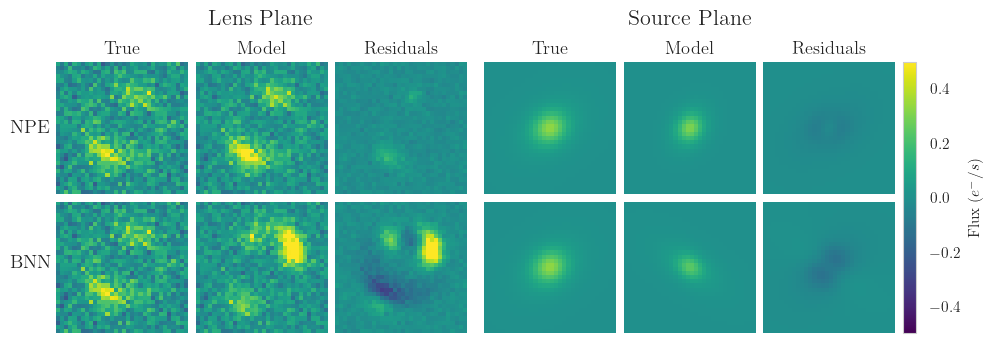

In [44]:
# Need to define priors for the SBI inference. For simplicity, keep it the same as the training set.

rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

seed = 42
test_number = 1000
weird_index = [[0]]
#weird_index = [[3,8,9,10]]
# weird_index = [[8]]
# weird_index = [[310,111,112,113,118,119,210]]
# weird_index = [[500,501,502,503,504,505,506,507,508,509]]

prior_low = [0.5, -0.2, -0.2, -1, -1, -0.05, -0.05, 19, 0.5, 2, -0.2, -0.2]
prior_high = [3.0, 0.2, 0.2, 1, 1, 0.05, 0.05, 24, 1, 4, 0.2, 0.2]
limits = np.array([prior_low, prior_high])

SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_median_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr = array_dump

config_file = '../SBI_WG/12_model_test_des_real.yaml'
test_set = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/12_model_test_des_real.yaml'
test_set_model = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/12_model_test_des_real_source.yaml'
source_set = dl.make_dataset(config_file, return_planes=True)

config_file = '../SBI_WG/12_model_test_des_real_source.yaml'
source_set_model = dl.make_dataset(config_file, return_planes=True)

for i, index in enumerate(np.ravel(weird_index[0])):

  sample_BNN = BNNsamples[:,index,:]
  samples = np.array(SBI_sample_array[0,index])
  logp = np.array(SBI_logp_array[0,index])
  best_fit_t = SBI_median_arr[0,index,:]
  max_like_t = SBI_max_like_arr[0,index,:]

  BNN_model_param = np.median(sample_BNN, axis=0)

  BNN_model_image, BNN_model_source = update_image_source(test_set_model, source_set_model, BNN_model_param, index)

  SBI_model_param = max_like_t
  SBI_model_image, SBI_model_source = update_image_source(test_set_model, source_set_model, SBI_model_param, index)

  observed_image = test_set.CONFIGURATION_1_images[:test_number][index][0]
  observed_source = source_set.CONFIGURATION_1_planes[:test_number][index][1,0]

  observed_noise = np.sqrt(np.square(observed_image-test_set.CONFIGURATION_1_planes[:test_number][index][1,0]))

  plot_residuals_combined(observed_image, SBI_model_image, observed_source, SBI_model_source, 'NPE', observed_image, BNN_model_image, observed_source, BNN_model_source, 'BNN')
  plt.savefig('12_param_single_image_combined_%s_%s.pdf'%(seed,index),format='pdf',bbox_inches = "tight")


We also plot the posterior distribution for both NPE and BNN models for that individual lens.

In [54]:
sns.reset_defaults()

Removed no burn in
Removed no burn in


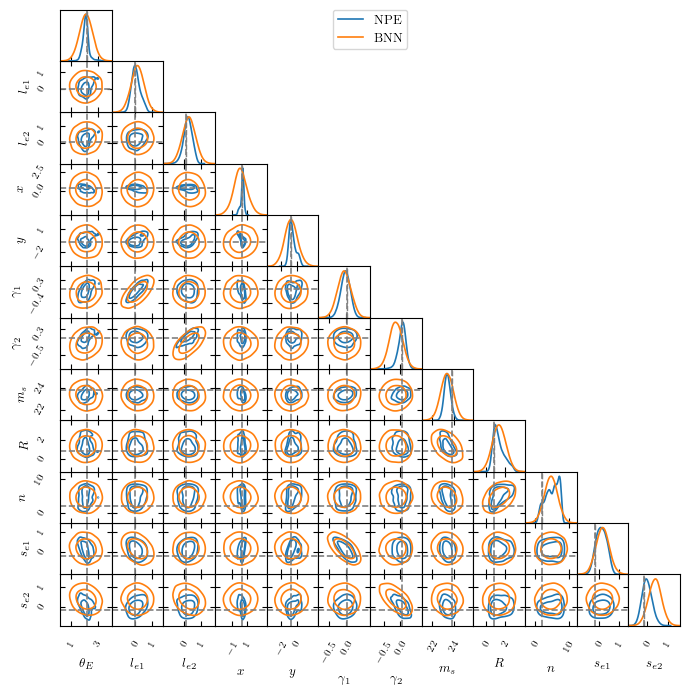

In [53]:
plot_pretty()
rcParams.update({"text.usetex": True})
rcParams['font.family'] = 'serif'

seed = 42
test_number = 1000
weird_index = [[0]]
# weird_index = [[1,2,3,8,9,10]]
prior_low = [0.5, -0.2, -0.2, -1, -1, -0.05, -0.05, 19, 0.5, 2, -0.2, -0.2]
prior_high = [3.0, 0.2, 0.2, 1, 1, 0.05, 0.05, 24, 1, 4, 0.2, 0.2]
limits = np.array([prior_low, prior_high])

SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_median_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr = array_dump


for i, index in enumerate(np.ravel(weird_index[0])):

  sample_BNN = BNNsamples[:,index,:]
  samples = np.array(SBI_sample_array[0,index])
  logp = np.array(SBI_logp_array[0,index])
  best_fit_t = SBI_median_arr[0,index,:]
  max_like_t = SBI_max_like_arr[0,index,:]

  config_file = '../SBI_WG/12_model_test_des_real.yaml'
  test_set = dl.make_dataset(config_file, return_planes=True)

  config_file = '../SBI_WG/12_model_test_des_real.yaml'
  test_set_model = dl.make_dataset(config_file, return_planes=True)

  config_file = '../SBI_WG/12_model_test_des_real_source.yaml'
  source_set = dl.make_dataset(config_file, return_planes=True)

  config_file = '../SBI_WG/12_model_test_des_real_source.yaml'
  source_set_model = dl.make_dataset(config_file, return_planes=True)

  true_theta_E = test_set_model.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].to_numpy()[index]
  true_le1 = test_set_model.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g'].to_numpy()[index]
  true_le2 = test_set_model.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g'].to_numpy()[index]
  true_x = test_set_model.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g'].to_numpy()[index]
  true_y = test_set_model.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g'].to_numpy()[index]

  true_g1 = test_set_model.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g'].to_numpy()[index]
  true_g2 = test_set_model.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g'].to_numpy()[index]

  true_smag = test_set_model.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].to_numpy()[index]
  true_R = test_set_model.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'].to_numpy()[index]
  true_n = test_set_model.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'].to_numpy()[index]
  true_se1 = test_set_model.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g'].to_numpy()[index]
  true_se2 = test_set_model.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g'].to_numpy()[index]

  true_parameter = np.array([true_theta_E, true_le1, true_le2, true_x, true_y, true_g1, true_g2, true_smag, true_R, true_n, true_se1, true_se2])

  SBIsingle = MCSamples(samples=np.array(samples),
                              names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'],
                        labels = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'])

  BNNsingle = MCSamples(samples=sample_BNN,
                              names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'],
                        labels = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'])

  g = plots.get_subplot_plotter(width_inch=8)
  g.settings.axes_fontsize=10
  g.settings.axes_labelsize=12
  g.settings.axis_tick_x_rotation=60
  g.settings.axis_tick_y_rotation=60
  g.settings.scaling_factor = 1
  g.settings.linewidth=1
  g.settings.title_limit_labels = False
  g.settings.tight_layout = False
  g.triangle_plot([SBIsingle, BNNsingle],[r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'], legend_labels=['NPE','BNN'],
                  colors=['tab:blue','tab:orange'],
                  contour_lws=1.2,
                  line_args=[{'color':'tab:blue', 'lw':1},{'color':'tab:orange', 'lw':1}],
                  markers={r'\theta_E':true_theta_E,r'l_{e1}':true_le1,r'l_{e2}':true_le2,r'x':true_x,r'y':true_y,r'\gamma_1':true_g1,r'\gamma_2':true_g2,r'm_s':true_smag,r'R':true_R,r'n':true_n,r's_{e1}':true_se1,r's_{e2}':true_se2},
                  marker_args ={'lw':1.2})
  for i in range(len(g.subplots[0,:])):
    g.subplots[i,i].axvline(x =true_parameter[i], color='gray', ls='--', lw=1)
  plt.savefig('12_single_image_corner_%s_%s.pdf'%(seed,index),format='pdf')

Finally, output latex-friendly statistics to quote in documents.

In [46]:
weird_index = [[0,1,2,3,8,9,10]]

for i, index in enumerate(np.ravel(weird_index[0])):


  sample_BNN = BNNsamples[:,index,:]
  samples = np.array(SBI_sample_array[0,index])
  logp = np.array(SBI_logp_array[0,index])
  # map = np.array(SBI_map_array[0,index])
  best_fit_t = SBI_median_arr[0,index,:]
  max_like_t = SBI_max_like_arr[0,index,:]

  SBIsingle = MCSamples(samples=np.array(samples),
                              names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'],
                        labels = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'])

  BNNsingle = MCSamples(samples=sample_BNN,
                              names = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'],
                        labels = [r'\theta_E',r'l_{e1}',r'l_{e2}',r'x',r'y',r'\gamma_1',r'\gamma_2',r'm_s',r'R',r'n',r's_{e1}',r's_{e2}'])


  print(f"Weird index {index}")
  print(SBIsingle.getLatex(params=None, limit=1, err_sig_figs=None))
  print(SBIsingle.getLatex(params=None, limit=2, err_sig_figs=None))
  print(BNNsingle.getLatex(params=None, limit=1, err_sig_figs=None))
  print(BNNsingle.getLatex(params=None, limit=2, err_sig_figs=None))

Removed no burn in
Removed no burn in
Weird index 0
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y', '\\gamma_1', '\\gamma_2', 'm_s', 'R', 'n', 's_{e1}', 's_{e2}'], ['2.11\\pm 0.25', '0.05^{+0.21}_{-0.31}', '0.22\\pm 0.26', '0.37^{+0.25}_{-0.12}', '-0.52^{+0.27}_{-0.56}', '-0.02\\pm 0.14', '0.060^{+0.13}_{-0.097}', '23.39^{+0.28}_{-0.32}', '1.32^{+0.33}_{-0.74}', '5.0^{+2.7}_{-1.5}', '0.12\\pm 0.27', '-0.01^{+0.23}_{-0.26}'])
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y', '\\gamma_1', '\\gamma_2', 'm_s', 'R', 'n', 's_{e1}', 's_{e2}'], ['2.11^{+0.50}_{-0.52}', '0.05^{+0.57}_{-0.45}', '0.22^{+0.50}_{-0.50}', '0.37^{+0.37}_{-0.58}', '-0.52^{+1.0}_{-0.70}', '-0.02^{+0.26}_{-0.28}', '0.06^{+0.22}_{-0.26}', '23.39^{+0.63}_{-0.60}', '1.32^{+1.3}_{-0.92}', '5.0^{+2.9}_{-3.6}', '0.12^{+0.49}_{-0.49}', '-0.01^{+0.51}_{-0.45}'])
(['\\theta_E', 'l_{e1}', 'l_{e2}', 'x', 'y', '\\gamma_1', '\\gamma_2', 'm_s', 'R', 'n', 's_{e1}', 's_{e2}'], ['2.13\\pm 0.50', '0.14\\pm 0.39', '0.28\\pm 0.39', '0.12\\pm 0.91'